In [25]:
# Datenzugriff
from configs.path_manager import get_path
from models import *
import pickle

# Utils
from src.utils.new_filter import *
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [26]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*30     # 30 min
this_version = "CP_Lateness_v00"

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen (60 Tage)

In [27]:
# Jobs
df_jobs_times = Job.get_dataframe(version="base")
df_jobs_times = df_jobs_times[df_jobs_times.Arrival <= 60*24*60]
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,base
1,J25-0001,6,129,1440,2338,open,base
2,J25-0002,0,198,1440,3744,open,base
3,J25-0003,2,243,1440,3379,open,base
4,J25-0004,3,287,1440,4856,open,base
5,J25-0005,1,498,1440,3106,open,base
...,...,...,...,...,...,...,...
1187,J25-1187,5,85934,86400,88481,open,base
1188,J25-1188,8,85975,86400,88866,open,base
1189,J25-1189,1,86001,86400,88375,open,base


In [28]:
Job.add_jobs_from_dataframe(df_jobs_times, version=this_version, status = "open")

✅ 1193 Jobs (Version 'CP_Lateness_v00') wurden hinzugefügt oder aktualisiert.


In [29]:
# Routings
df_routings = RoutingOperation.get_dataframe()
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


In [30]:
def get_jssp_for_jobs(df_jobs_times, df_routings):
    """
    Erstellt ein JSSP-kompatibles DataFrame durch Verknüpfung von Job-Zeitdaten mit Routings.

    Parameter:
    - df_jobs_times: DataFrame mit mindestens den Spalten 'Job' und 'Routing_ID'.
    - df_routings: DataFrame mit Spalte 'Routing_ID' und den zugehörigen Operationsdaten.

    Rückgabe:
    - df_jssp: DataFrame mit allen für das JSSP notwendigen Informationen, inklusive 'Job' und den Operationen.
    """
    # 1. Relevante Spalten extrahieren
    df_job_ids = df_jobs_times[['Job', 'Routing_ID']].copy()

    # 2. Merge mit df_routings über Routing_ID
    df_jssp = df_job_ids.merge(df_routings, on='Routing_ID')

    return df_jssp


def get_prev_schedule(this_version:str, current_day_numb=1):
    ## Hole den vorherigen Schedule
    df_schedule = Schedule.get_schedule_as_dataframe(date=current_day_numb - 1, version=this_version)

    # Hole die offenen Operationen für die enthaltenen Jobs
    df_open_ops = JobOperation.get_dataframe(version=this_version, jobs=df_schedule["Job"].unique().tolist(),
                                          status="open")

    # Mache ein Inner Join auf ["Job", "Operation"]
    df_schedule_prev = df_schedule.merge(df_open_ops[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
    return df_schedule_prev

In [31]:
df_jssp = get_jssp_for_jobs(df_jobs_times, df_routings)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
11924,J25-1192,3,4,M06,9
11925,J25-1192,3,5,M08,52
11926,J25-1192,3,6,M07,85


In [32]:
JobOperation.add_from_dataframe(df_jssp, version=this_version, status="open")

✅ 11930 JobOperation-Einträge (Version 'CP_Lateness_v00', Status 'open') wurden hinzugefügt oder aktualisiert.


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [33]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [34]:
# alle aktuelle "offenen" Jobs ("neue" und unerledigte Jobs)
df_jobs_times_current = Job.get_dataframe(version=this_version, arrival_time_max=day_start, status="open")
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,CP_Lateness_v00
1,J25-0001,6,129,1440,2338,open,CP_Lateness_v00
2,J25-0002,0,198,1440,3744,open,CP_Lateness_v00
3,J25-0003,2,243,1440,3379,open,CP_Lateness_v00
4,J25-0004,3,287,1440,4856,open,CP_Lateness_v00
5,J25-0005,1,498,1440,3106,open,CP_Lateness_v00
6,J25-0006,9,790,1440,3539,open,CP_Lateness_v00
7,J25-0007,5,925,1440,2929,open,CP_Lateness_v00
8,J25-0008,4,988,1440,3541,open,CP_Lateness_v00
9,J25-0009,7,1004,1440,3578,open,CP_Lateness_v00


In [35]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


In [36]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = None
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling

In [37]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum_by_tardiness_and_earliness(
    df_jssp_current, df_jobs_times_current, earliest_start_column = "Ready Time", w_t= 5,
    msg=False, timeLimit=max_time, gapRel=0.01)
df_schedule


Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.03 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0006,9,790,1440,3539,9,M07,3494,45,3539
155,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
156,J25-0000,8,79,1440,3660,9,M08,3586,74,3660


In [38]:
# json_schedule = df_schedule.to_dict(orient='records')
Schedule.add_schedule_from_dataframe(df_schedule, version=this_version, date=day_numb)

✅ Schedule hinzugefügt (Version=CP_Lateness_v00, Date=1)


### Simulation

In [39]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0005 started on M00
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 00:42:00] Job J25-0005 finished on M00 (after 42 minutes)
[Day 1 00:43:00] Job J25-0011 started on M00
[Day 1 01:13:00] Job J25-0013 finished on M01 (after 73 minutes)
[Day 1 01:21:00] Job J25-0001 started on M01
[Day 1 01:27:00] Job J25-0007 finished on M02 (after 87 minutes)
[Day 1 01:27:00] Job J25-0013 started on M02
[Day 1 01:30:00] Job J25-0011 finished on M00 (after 47 minutes)
[Day 1 01:30:00] Job J25-0010 started on M00
[Day 1 01:57:00] Job J25-0010 finished on M00 (after 27 minutes)
[Day 1 01:57:00] Job J25-0000 started on M00
[Day 1 02:19:00] Job J25-0001 finished on M01 (after 58 minutes)
[Day 1 02:19:00] Job J25-0007 started on M01
[Day 1 02:21:00] Job J25-0007 finished on M01 (after 02 minutes)
[Day 1 02:21:00] Job J25-0003 started on M01
[Day 1 02:21:00] Job J25-0007 started on M05
[Day 1 03:01:00] Job J25-0013 finished on M02 (aft

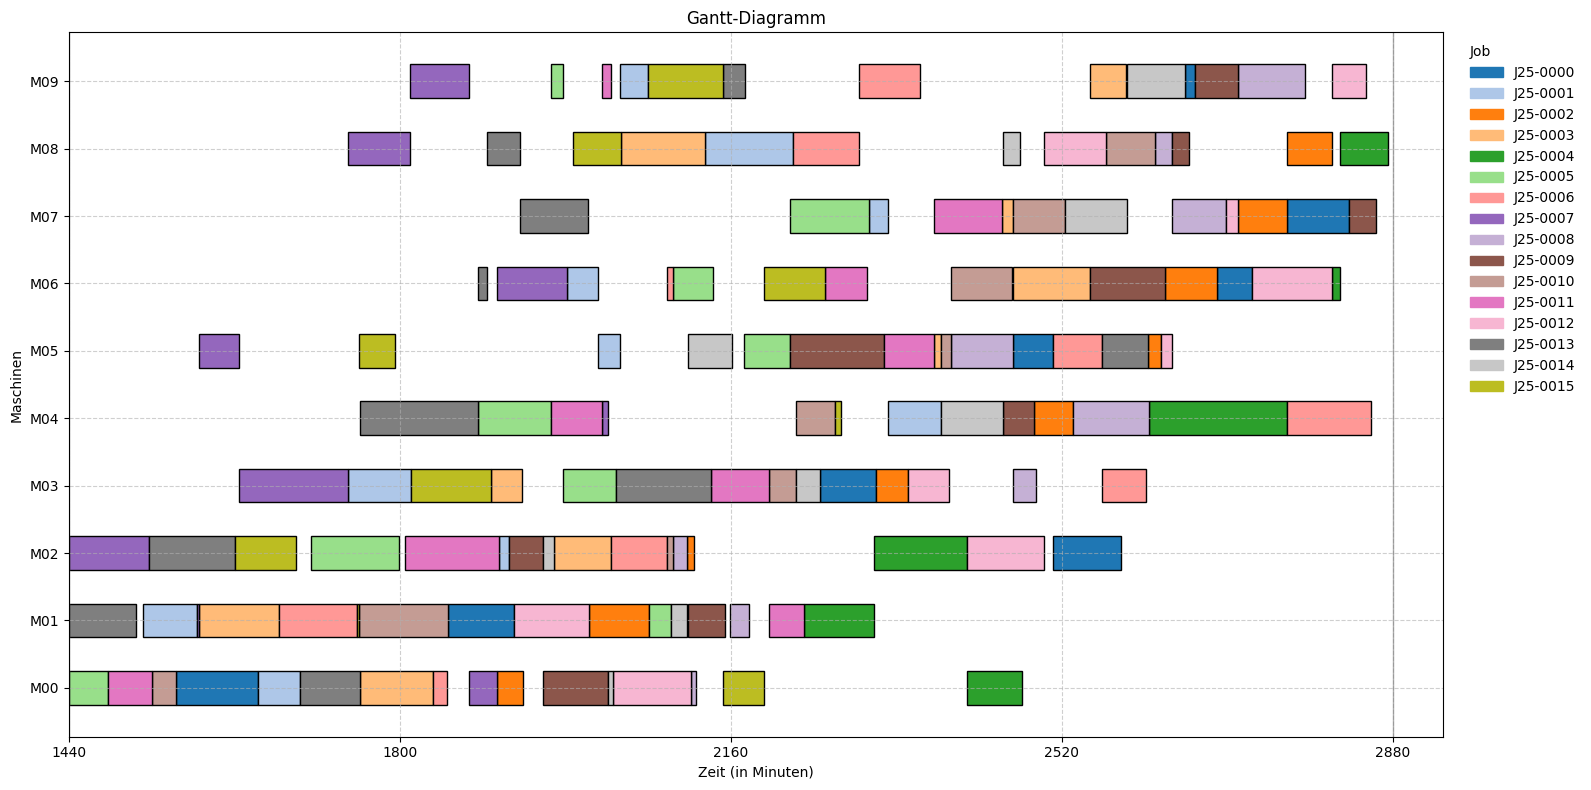

In [40]:
df_execution = simulation.get_finished_operations_df()
show.plot_gantt(df_execution, perspective="Machine")

In [41]:
df_execution

,Routing_ID,Job,Operation,Machine,Arrival,Start,Processing Time,End
0,8,J25-0000,0,M00,79,1557.0,89.0,1646.0
1,8,J25-0000,1,M01,79,1852.0,72.0,1924.0
2,8,J25-0000,2,M03,79,2257.0,61.0,2318.0
3,8,J25-0000,3,M05,79,2467.0,43.0,2510.0
4,8,J25-0000,4,M02,79,2510.0,74.0,2584.0
5,8,J25-0000,5,M09,79,2654.0,11.0,2665.0
...,...,...,...,...,...,...,...,...
136,5,J25-0015,3,M03,1436,1812.0,87.0,1899.0
137,5,J25-0015,4,M08,1436,1988.0,53.0,2041.0
138,5,J25-0015,5,M09,1436,2070.0,81.0,2151.0


In [42]:
JobOperation.add_from_dataframe(df_execution, version=this_version, status="finished")

✅ 142 JobOperation-Einträge (Version 'CP_Lateness_v00', Status 'finished') wurden hinzugefügt oder aktualisiert.


C:\Users\konra\Coding\HTWD_Minimalinvasives_Job-Shop_Scheduling\src\utils\presenter.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


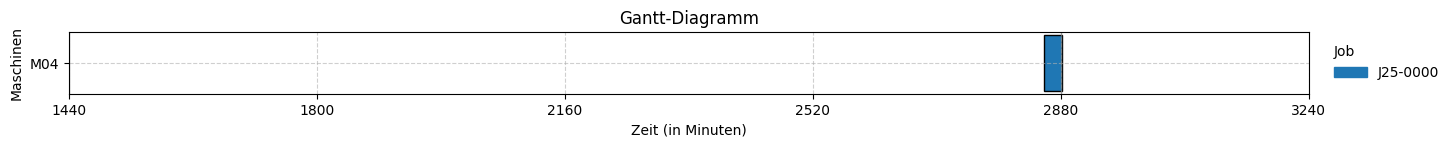

✅ 1 JobOperation-Einträge (Version 'CP_Lateness_v00', Status 'active') wurden hinzugefügt oder aktualisiert.


,Routing_ID,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,8,J25-0000,8,M04,79,2856.0,26,26.0,2882.0,2882.0


In [43]:
df_active = simulation.get_active_operations_df()
if df_active is not None:
    show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")
    JobOperation.add_from_dataframe(df_active, version=this_version, status="active")
df_active

In [44]:
JobOperation.update_jobs_with_nothing_to_schedule(version=this_version)

✅ 2 Job(s) wurden auf 'nothing to schedule' gesetzt (Version 'CP_Lateness_v00').


['J25-0001', 'J25-0013']

In [45]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,9,M08,3586,74,3660
1,J25-0002,0,198,1440,3744,9,M09,3723,21,3744
2,J25-0003,2,243,1440,3379,9,M04,3346,33,3379
3,J25-0004,3,287,1440,4856,6,M07,2981,85,3066
4,J25-0004,3,287,1440,4856,7,M03,3066,98,3164
5,J25-0004,3,287,1440,4856,8,M09,3164,22,3186
...,...,...,...,...,...,...,...,...,...,...
11,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
12,J25-0010,0,1025,1440,3345,9,M09,3324,21,3345
13,J25-0011,1,1030,1440,3210,9,M08,3180,30,3210
